In [66]:
import matplotlib.pyplot as plt
import pandas as pd
# import numpy as np
# import pandas as pd
import seaborn as sns
import geopandas as gpd
# import scipy.stats as stats
# import matplotlib.pyplot as plt
from src import *
import statsmodels.api as sm
from factor_analyzer import FactorAnalyzer
# het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.diagnostic import het_arch

In [67]:
# def create_composite_feature(dataframe, feature_list, new_feature_name, drop_features=False):
#     """
#     Create a composite feature from a list of features.
#     
#     Parameters
#     ----------
#     dataframe : pandas.DataFrame
#         The dataframe containing the features.
#     feature_list : list
#         The list of features to combine.
#     new_feature_name : str
#         The name of the new feature.
#     drop_features : bool, default False
#         Whether to drop the features used to create the new feature.
#         
#     Returns
#     -------
#     dataframe : pandas.DataFrame
#         The dataframe with the new feature added.
#     """    
#     dataframe[new_feature_name] = dataframe[feature_list].mean(axis=1)
#     if drop_features:
#         dataframe.drop(columns=feature_list, inplace=True)
#     return dataframe
# 
# 
# def create_change_features(dataframe, drop_before_after=False):
#     """
#     Create change features from before and after features.
#     
#     Parameters
#     ----------
#     dataframe : pandas.DataFrame
#         The dataframe containing the features.
#     drop_before_after : bool, default False
#         Whether to drop the before and after features.
#         
#     Returns
#     -------
#     dataframe : pandas.DataFrame
#         The dataframe with the change features added.
#         
#     Notes
#     -----
#     The change features are created by subtracting the before feature from the after feature.
#     
#     The change features are inserted after the after feature.
#     
#     Examples
#     --------
#     >>> import pandas as pd
#     >>> df = pd.DataFrame({'a_before': [1, 2, 3],
#                            'a_after': [4, 5, 6],
#                            'b_before': [7, 8, 9],
#                            'b_after': [10, 11, 12]})
#     >>> df = create_change_features(df)
#     """
#     dataframe = dataframe.copy()
#     
#     for col in dataframe.columns:
#         
#         if col.endswith('_before') or col.endswith('_after'):
#             base_col = col.rsplit('_', 1)[0]
#             before_col = base_col + '_before'
#             after_col = base_col + '_after'
#             
#             if before_col in dataframe.columns and after_col in dataframe.columns:
#                 change_col = base_col + '_change'
#                 dataframe[change_col] = dataframe[after_col] - dataframe[before_col]
#                 change_col_index = max(dataframe.columns.get_loc(before_col), dataframe.columns.get_loc(after_col)) + 1
#                 change_col_data = dataframe[change_col]
#                 dataframe.drop(columns=[change_col], inplace=True)
#                 dataframe.insert(change_col_index, change_col, change_col_data)
#                 
#                 if drop_before_after:
#                     dataframe.drop(columns=[before_col, after_col], inplace=True)
#                     
#     return dataframe
# 
# 
# # def create_intervention_features(dataframe):
# #     dataframe = dataframe.copy()
# # 
# #     for col in dataframe.columns:
# # 
# #         if col.startswith('trained') or col.startswith('adopted'):
# #             intervention_col = col.split('_', 1)[1]
# #             trained_col = 'trained_' + intervention_col
# #             adopted_col = 'adopted_' + intervention_col
# #             
# #             if trained_col in dataframe.columns and adopted_col in dataframe.columns:
# #                 # 

In [68]:
survey = pd.read_excel('../data/raw/NARIG_Survey.xlsx', usecols='A:EG')
column_names = pd.read_json('../data/processed/json/column_names.json', typ='series')

kenya = gpd.read_file('../data/processed/geojson/kenya.geojson')
counties = gpd.read_file('../data/processed/geojson/kenya_counties.geojson')
sub_counties = gpd.read_file('../data/processed/geojson/kenya_sub_counties.geojson')
wards = gpd.read_file('../data/processed/geojson/kenya_wards.geojson')
narig_wards = gpd.read_file('../data/processed/geojson/narig_wards.geojson')
kenya.crs = counties.crs = sub_counties.crs = wards.crs = narig_wards.crs = 'EPSG:4326'
makueni_county = counties[counties['county'] == 'Makueni']
makueni_sub_counties = sub_counties[sub_counties['county'] == 'Makueni']
makueni_wards = wards[wards['county'] == 'Makueni']

survey.rename(columns=column_names, inplace=True)

replace_map = {'Diasgree': 'Disagree',
               'Kako': 'Waia/Kako',
               'Mtito': 'Mtito Andei'}

reverse_map = {v: k for k, v in ordinal_map.items()}

survey.replace(replace_map, inplace=True)
survey.replace(ordinal_map, inplace=True)

survey = makueni_wards.merge(survey, on='ward', how='right')

survey['age'] = survey['age'].replace(0, np.nan)
survey['gender'] = survey['gender'].str.split().str[-1]

orig_col_order = list(survey.columns)

# fig, ax = plt.subplots(1, 2, figsize=(30, 15))
# sns.heatmap(survey.set_index('value_chain').sort_index().isnull(), cbar=False, ax=ax[0])

demographic_cols = survey.columns[:12].tolist()
attitude_cols = survey.columns[12:20].tolist()
knowledge_cols = survey.columns[20:25].tolist()
practice_cols = survey.columns[25:30].tolist()
# vc_performance_cols = survey.columns[30:-6].tolist()
performance_cols = survey.columns[-6:].tolist()

value_chains = list(survey['value_chain'].unique())

narig_dfs = {vc: survey[survey['value_chain'] == vc].dropna(axis=1, how='all') for vc in value_chains}

for k, v in narig_dfs.items():
    v.columns = v.columns.str.replace('_\d', '', regex=True)
    v.dropna(axis=0, inplace=True)
    # v = create_composite_feature(v, attitude_cols, 'farmer_attitudes')
    # v = create_composite_feature(v, knowledge_cols, 'farmer_knowledge')
    # v = create_composite_feature(v, practice_cols, 'farmer_practices')
    # v = create_composite_feature(v, performance_cols, 'project_performance')
    # v = engineer_change_features(v)

narig_dfs['survey_df'] = pd.concat(narig_dfs.values(), ignore_index=True)
narig_dfs['survey_df'] = narig_dfs['survey_df'][[col for col in orig_col_order if col in narig_dfs['survey_df'].columns]]

narig_dfs['survey_df'].replace(reverse_map, inplace=True)
numeric_cols = narig_dfs['survey_df'].select_dtypes('number').columns.tolist()
narig_dfs['survey_df'].replace(ordinal_map, inplace=True)

# narig_dfs['survey_df'] = create_change_features(narig_dfs['survey_df'], drop_before_after=False)
# narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], attitude_cols, 'farmer_attitudes', drop_features=False)
# narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], knowledge_cols, 'farmer_knowledge', drop_features=False)
# narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], practice_cols, 'farmer_practices', drop_features=False)
narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], performance_cols, 'project_performance', drop_features=False)

for k, v in narig_dfs.items():
    for col in v.select_dtypes('object').columns:
        v[col] = v[col].astype('category')
    for col in v.select_dtypes('float').columns:
        if v[col].apply(float.is_integer).all():
            v[col] = v[col].astype(int)
    print(k)

# sns.heatmap(narig_dfs['survey_df'].set_index('value_chain').sort_index().isnull(), cbar=False, ax=ax[1])
# plt.show()
palette = sns.color_palette('Spectral', 6)
palette.reverse()

Tomato
Mango
Green gram
Indigenous chicken
survey_df


In [69]:
narig_dfs['survey_df']

,county,sub_county,ward,geometry,gender,age,education,monthly_income,household_size,family_head,...,adopted_vaccination,trained_hygiene_management,adopted_hygiene_management,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity,project_performance
0,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,64,Secondary,30000,3,Yes,...,NaN,NaN,NaN,2,2,1,2,2,2,1.833333
1,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,67,Secondary,20000,4,Yes,...,NaN,NaN,NaN,2,2,2,2,2,2,2.000000
2,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,33,Primary,5000,3,No,...,NaN,NaN,NaN,2,2,2,2,2,2,2.000000
3,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,73,Primary,800,6+,No,...,NaN,NaN,NaN,2,2,1,2,2,2,1.833333
4,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,71,Secondary,10000,5,Yes,...,NaN,NaN,NaN,2,2,2,2,2,2,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,85,Primary,16000,6+,No,...,Yes,Yes,Yes,1,1,1,1,1,1,1.000000
331,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,54,Primary,14000,6+,Yes,...,Yes,Yes,Yes,1,1,1,1,1,1,1.000000
332,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,60,Primary,16000,6+,Yes,...,Yes,Yes,Yes,1,1,1,1,1,1,1.000000
333,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,62,Primary,4500,5,No,...,Yes,Yes,Yes,2,2,2,2,2,2,2.000000


In [70]:
# # perform factor analysis (KMO)
# fa = FactorAnalyzer(n_factors=25, rotation='varimax')
# fa.fit(narig_dfs['survey_df'][performance_cols])
# kmo, kmo_model = fa.get_kmo()
# print(f'KMO: {kmo}')
# 
# # create scree plot using matplotlib
# plt.figure(figsize=(6.7, 4))
# 
# plt.scatter(range(1, narig_dfs['survey_df'][performance_cols].shape[1]+1), ev)
# plt.plot(range(1, narig_dfs['survey_df'][performance_cols].shape[1]+1), ev)
# plt.title('Scree Plot')
# plt.xlabel('Factors')
# plt.ylabel('Eigenvalue')
# plt.grid()
# plt.show()


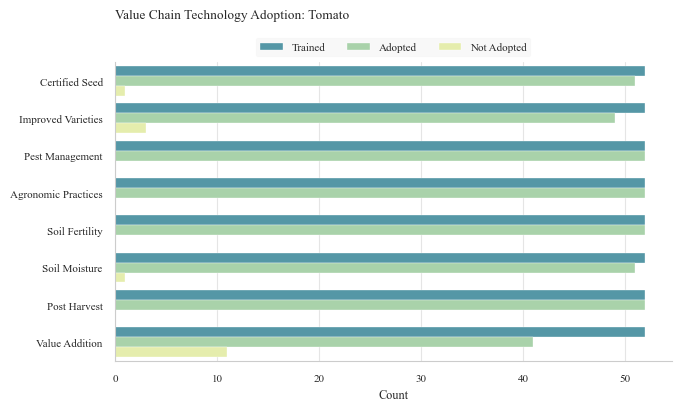

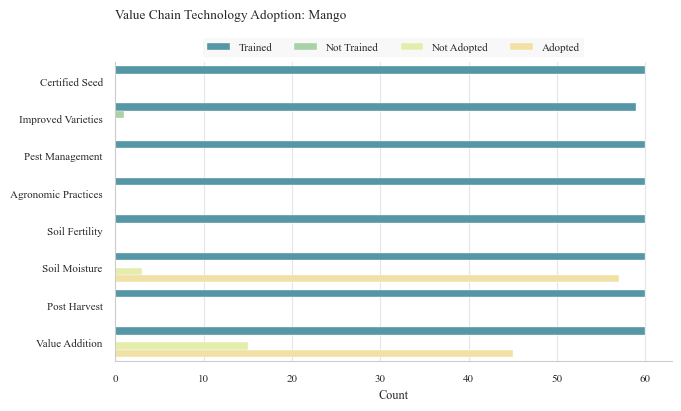

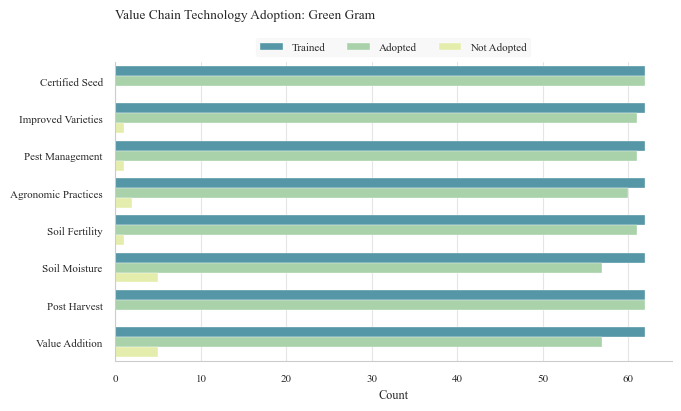

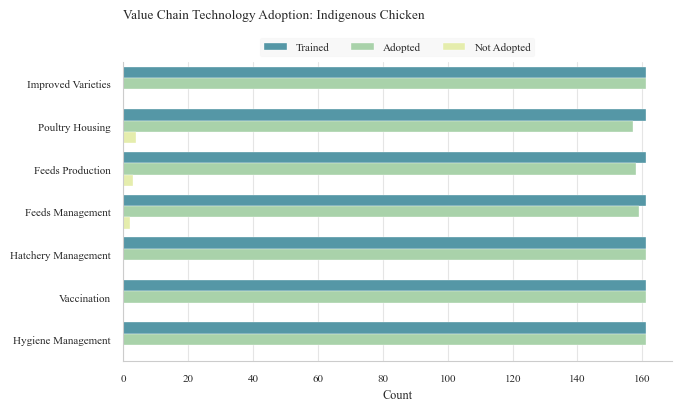

In [71]:
tmt = narig_dfs['Tomato']
mng = narig_dfs['Mango']
gg = narig_dfs['Green gram']
ic = narig_dfs['Indigenous chicken']


def create_technology_features(df):
    dataframe = df.copy()
    
    technology_cols = [col for col in dataframe.columns if col.startswith('trained') or col.startswith('adopted')]
    
    for col in dataframe.columns:
        
        if col in technology_cols:
            technology_col = col.split('_', 1)[1]
            trained_col = 'trained_' + technology_col
            adopted_col = 'adopted_' + technology_col
            
            if col.startswith('trained'):
                dataframe.loc[:, trained_col] = dataframe[trained_col].replace({'Yes': 'Trained', 'No': 'Not Trained'})
            elif col.startswith('adopted'):
                dataframe.loc[:, adopted_col] = dataframe[adopted_col].replace({'Yes': 'Adopted', 'No': 'Not Adopted'})
                
    dataframe = dataframe.melt(id_vars=[col for col in dataframe.columns if col not in technology_cols],
                               value_vars=technology_cols, var_name='Technology', value_name='Status')
    
    dataframe.loc[:, 'Technology'] = dataframe['Technology'].apply(lambda x: x.split('_', 1)[1].replace('_', ' ').title())
    
    return dataframe

tm = create_technology_features(tmt)
mn = create_technology_features(mng)
gg = create_technology_features(gg)
ic = create_technology_features(ic)

# technology_cols = [col for col in tmt.columns if col.startswith('trained') or col.startswith('adopted')]
# 
# for i, col in enumerate(tmt.columns):
#     if col in technology_cols:
#         technology_col = col.split('_', 1)[1]
#         trained_col = 'trained_' + technology_col
#         adopted_col = 'adopted_' + technology_col
# 
#         if col in technology_cols:
#             tmt.loc[:, trained_col] = tmt[trained_col].replace({'Yes': 'Trained', 'No': 'Not Trained'})
#             tmt.loc[:, adopted_col] = tmt[adopted_col].replace({'Yes': 'Adopted', 'No': 'Not Adopted'})
#             
# tmt = tmt.melt(id_vars=[col for col in tmt.columns if col not in technology_cols],
#                value_vars=technology_cols, var_name='Technology', value_name='Status')
# 
# tmt.loc[:, 'Technology'] = tmt['Technology'].apply(lambda x: x.split('_', 1)[1].replace('_', ' ').title())
# 

# 

plt.figure(figsize=(6.7, 4))
sns.countplot(data=tm, y='Technology', hue='Status', palette=palette[:tm.Status.nunique()])
plt.title('Value Chain Technology Adoption: Tomato', y=1.12, loc='left')
plt.xlabel('Count')
plt.ylabel('')
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1),
           facecolor='gray', framealpha=0.05)
sns.despine()
plt.show()

plt.figure(figsize=(6.7, 4))
sns.countplot(data=mn, y='Technology', hue='Status', palette=palette[:mn.Status.nunique()])
plt.title('Value Chain Technology Adoption: Mango', y=1.12, loc='left')
plt.xlabel('Count')
plt.ylabel('')
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1),
           facecolor='gray', framealpha=0.05)
sns.despine()
plt.show()

plt.figure(figsize=(6.7, 4))
sns.countplot(data=gg, y='Technology', hue='Status', palette=palette[:gg.Status.nunique()])
plt.title('Value Chain Technology Adoption: Green Gram', y=1.12, loc='left')
plt.xlabel('Count')
plt.ylabel('')
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1),
           facecolor='gray', framealpha=0.05)
sns.despine()
plt.show()

plt.figure(figsize=(6.7, 4))
sns.countplot(data=ic, y='Technology', hue='Status', palette=palette[:ic.Status.nunique()])
plt.title('Value Chain Technology Adoption: Indigenous Chicken', y=1.12, loc='left')
plt.xlabel('Count')
plt.ylabel('')
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1),
           facecolor='gray', framealpha=0.05)
sns.despine()
plt.show()

In [72]:
trained_adopted_totals = pd.DataFrame({'Trained': [tm[tm['Status'] == 'Trained'].shape[0],
                                                   mn[mn['Status'] == 'Trained'].shape[0],
                                                   gg[gg['Status'] == 'Trained'].shape[0],
                                                   ic[ic['Status'] == 'Trained'].shape[0]],
                                       'Not Trained': [tm[tm['Status'] == 'Not Trained'].shape[0],
                                                       mn[mn['Status'] == 'Not Trained'].shape[0],
                                                       gg[gg['Status'] == 'Not Trained'].shape[0],
                                                       ic[ic['Status'] == 'Not Trained'].shape[0]],
                                       'Adopted': [tm[tm['Status'] == 'Adopted'].shape[0],
                                                   mn[mn['Status'] == 'Adopted'].shape[0],
                                                   gg[gg['Status'] == 'Adopted'].shape[0],
                                                   ic[ic['Status'] == 'Adopted'].shape[0]],
                                       'Not Adopted': [tm[tm['Status'] == 'Not Adopted'].shape[0],
                                                       mn[mn['Status'] == 'Not Adopted'].shape[0],
                                                       gg[gg['Status'] == 'Not Adopted'].shape[0],
                                                       ic[ic['Status'] == 'Not Adopted'].shape[0]]},
                                      index=['Tomato', 'Mango', 'Green Gram', 'Indigenous Chicken'])

trained_adopted_totals['Total'] = trained_adopted_totals.sum(axis=1)
trained_adopted_totals.loc['Total'] = trained_adopted_totals.sum(axis=0)
# trained_adopted_totals['Percentage'] = trained_adopted_totals['Total'] / trained_adopted_totals['Total'].sum() * 100
# trained_adopted_totals['Percentage'] = trained_adopted_totals['Percentage'].round(2)
# trained_adopted_totals['Percentage'] = trained_adopted_totals['Percentage'].astype(str) + '%'

display(trained_adopted_totals)

,Trained,Not Trained,Adopted,Not Adopted,Total
Tomato,416,0,400,16,832
Mango,479,1,102,18,600
Green Gram,496,0,481,15,992
Indigenous Chicken,1127,0,1118,9,2254
Total,2518,1,2101,58,4678


,Ward,Sample,Returned,Percentage
0,Mtito Andei,119,122,102.52%
1,Thange,113,77,68.14%
2,Waia/Kako,99,77,77.78%
3,Tulimani,63,59,93.65%
4,Total,394,335,85.03%


,Ward,Type,Count
0,Mtito Andei,Sample,119
1,Thange,Sample,113
2,Waia/Kako,Sample,99
3,Tulimani,Sample,63
4,Mtito Andei,Returned,122
5,Thange,Returned,77
6,Waia/Kako,Returned,77
7,Tulimani,Returned,59


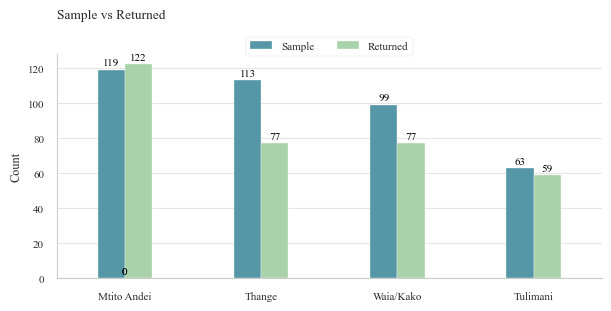

In [73]:
# Value count ward
ward_counts = pd.DataFrame({'Ward': ['Mtito Andei', 'Thange', 'Waia/Kako', 'Tulimani'],
                            'Sample': [119, 113, 99, 63]})
ward_counts['Returned'] = narig_dfs['survey_df'].ward.value_counts().values
ward_counts.set_index('Ward', inplace=True)
ward_counts.loc['Total'] = ward_counts.sum()

ward_counts['Percentage'] = ward_counts['Returned'] / ward_counts['Sample'] * 100
ward_counts['Percentage'] = ward_counts['Percentage'].round(2)
ward_counts['Percentage'] = ward_counts['Percentage'].astype(str) + '%'
# Add total row

ward_counts.reset_index(inplace=True)
display(ward_counts)

# Melt the dataframe
ward_counts_melted = pd.melt(ward_counts.drop(4, axis=0), id_vars='Ward', value_vars=['Sample', 'Returned'], var_name='Type', value_name='Count')
display(ward_counts_melted)

# Bar chart comparing Sample vs Returned (staggered)
fig, ax = plt.subplots(figsize=(6, 3))

sns.barplot(data=ward_counts_melted, x='Ward', y='Count', hue='Type', palette=palette[:2], width=0.4, ax=ax)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
    
ax.set_title('Sample vs Returned', y=1.12, loc='left')
ax.set_xlabel('')
ax.set_ylabel('Count')
# ax.set_ylabel('')
ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))
sns.despine()
plt.show()

,count,mean,std,min,25%,50%,75%,max
age,335.0,52.244776,13.656602,22.0,42.0,53.0,63.0,85.0


C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\1638453361.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=90)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\1638453361.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=90)


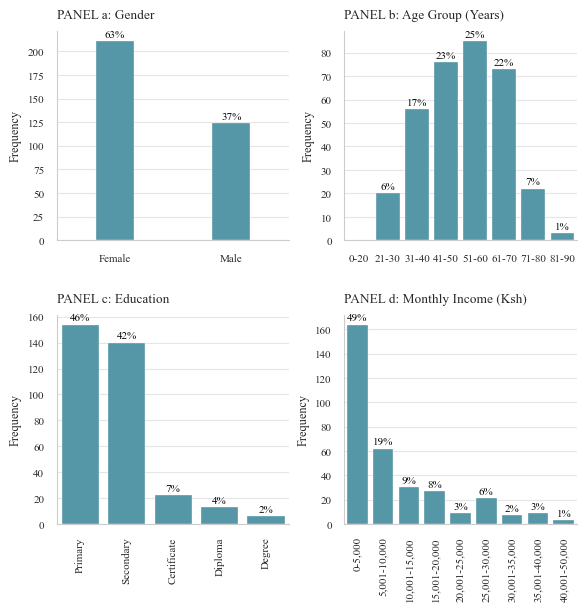

C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\1638453361.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=90)


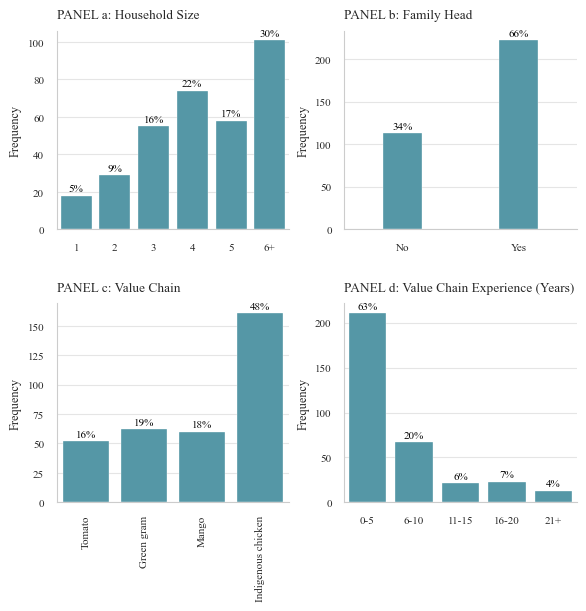

In [74]:
display(narig_dfs['survey_df'][['age']].describe().T)

# Create a new age column with the age groups
narig_dfs['survey_df']['age_group'] = pd.cut(narig_dfs['survey_df']['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90], labels=['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])

# Create a new income column with the income groups
narig_dfs['survey_df']['income_group'] = pd.cut(narig_dfs['survey_df']['monthly_income'], bins=[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 50000], labels=['0-5,000', '5,001-10,000', '10,001-15,000', '15,001-20,000', '20,001-25,000', '25,001-30,000', '30,001-35,000', '35,001-40,000', '40,001-50,000'])

# Create a new vc_experience column with the vc_experience groups
narig_dfs['survey_df']['vc_experience_binned'] = pd.cut(narig_dfs['survey_df']['vc_experience'], bins=[0, 5, 10, 15, 20, np.inf], labels=['0-5', '6-10', '11-15', '16-20', '21+'])

# Plot age groups
fig, ax = plt.subplots(2, 2, figsize=(5.75, 6), gridspec_kw={'hspace': 0.1})

sns.countplot(data=narig_dfs['survey_df'], x='gender', width=0.33, ax=ax[0,0], color=palette[0])
sns.countplot(data=narig_dfs['survey_df'], x='age_group', ax=ax[0,1], color=palette[0])
sns.countplot(data=narig_dfs['survey_df'], x='education',
              order=['Primary', 'Secondary', 'Certificate', 'Diploma', 'Degree'], ax=ax[1,0], color=palette[0])
sns.countplot(data=narig_dfs['survey_df'], x='income_group', ax=ax[1,1], color=palette[0])

# Annotate the plots with percentages
for i in range(2):
    for j in range(2):
        for p in ax[i,j].patches:
            ax[i,j].annotate(f"{p.get_height() / narig_dfs['survey_df'].shape[0] * 100:.0f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
            
ax[0,0].set_title('PANEL a: Gender', y=1.02, loc='left')
ax[0,1].set_title('PANEL b: Age Group (Years)', y=1.02, loc='left')
ax[1,0].set_title('PANEL c: Education', y=1.02, loc='left')
ax[1,1].set_title('PANEL d: Monthly Income (Ksh)', y=1.02, loc='left')

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')
ax[0,0].set_ylabel('Frequency')
ax[0,1].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')
ax[1,1].set_ylabel('Frequency')

# ax[0].set_title('Gender', y=1.02, loc='left')
# ax[1].set_title('Age Group', y=1.02, loc='left')
# ax[2].set_title('Education', y=1.02, loc='left')
# 
# ax[0].set_xlabel('')
# ax[1].set_xlabel('')
# ax[2].set_xlabel('')
# 
# ax[0].set_ylabel('Count')
# ax[1].set_ylabel('')
# ax[2].set_ylabel('')

ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=90)
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=90)

sns.despine()
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(5.75, 6), gridspec_kw={'hspace': 0.1})

sns.countplot(data=narig_dfs['survey_df'], x='household_size', ax=ax[0,0], color=palette[0])
sns.countplot(data=narig_dfs['survey_df'], x='family_head', width=0.33, ax=ax[0,1], color=palette[0])
sns.countplot(data=narig_dfs['survey_df'], x='value_chain',
              order=['Tomato', 'Green gram', 'Mango', 'Indigenous chicken'], ax=ax[1,0], color=palette[0])
sns.countplot(data=narig_dfs['survey_df'], x='vc_experience_binned', ax=ax[1,1], color=palette[0])

# Annotate the plots with percentages
for i in range(2):
    for j in range(2):
        for p in ax[i,j].patches:
            ax[i,j].annotate(f"{p.get_height() / narig_dfs['survey_df'].shape[0] * 100:.0f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
            
ax[0,0].set_title('PANEL a: Household Size', y=1.02, loc='left')
ax[0,1].set_title('PANEL b: Family Head', y=1.02, loc='left')
ax[1,0].set_title('PANEL c: Value Chain', y=1.02, loc='left')
ax[1,1].set_title('PANEL d: Value Chain Experience (Years)', y=1.02, loc='left')

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')
ax[0,0].set_ylabel('Frequency')
ax[0,1].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')
ax[1,1].set_ylabel('Frequency')

            
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=90)

sns.despine()
plt.show()

In [75]:
df = narig_dfs['survey_df']

# df.columns = df.columns.str.replace('_', ' ').str.capitalize()

farmer_demographics = df[demographic_cols].rename(columns={col: col.replace('_', ' ').capitalize() for col in demographic_cols})
farmer_attitudes = df[attitude_cols].rename(columns={col: col.replace('_', ' ').capitalize() for col in attitude_cols}).replace(reverse_map)
farmer_knowledge = df[knowledge_cols].rename(columns={col: col.replace('_', ' ').capitalize() for col in knowledge_cols}).replace(reverse_map)
farmer_practices = df[practice_cols].rename(columns={col: col.replace('_', ' ').capitalize() for col in practice_cols}).replace(reverse_map)
performance = df[performance_cols].rename(columns={col: col.replace('_', ' ').capitalize() for col in performance_cols})

# farmer_attitudes.replace(reverse_map, inplace=True)
# farmer_knowledge.replace(reverse_map, inplace=True)
# farmer_practices.replace(reverse_map, inplace=True)

# display(farmer_attitudes)

display(farmer_attitudes[farmer_attitudes.columns[0]].value_counts(normalize=True))
display(farmer_knowledge[farmer_knowledge.columns[0]].value_counts(normalize=True))
display(farmer_practices[farmer_practices.columns[0]].value_counts(normalize=True))

# Melt the data to have 'Statement' and 'Response' columns
farmer_attitudes_melted = pd.melt(farmer_attitudes, var_name='Statement', value_name='Response', ignore_index=False)
# # farmer_attitudes_melted['Response'] = farmer_attitudes_melted['Response'].astype('category')
farmer_knowledge_melted = pd.melt(farmer_knowledge, var_name='Statement', value_name='Response', ignore_index=False)
# # farmer_knowledge_melted['Response'] = farmer_knowledge_melted['Response'].astype('category')
farmer_practices_melted = pd.melt(farmer_practices, var_name='Statement', value_name='Response', ignore_index=False)
# # farmer_practices_melted['Response'] = farmer_practices_melted['Response'].astype('category')

# Pivot the data to have 'Statement' as the index and 'Response' as the columns
farmer_attitudes_pivoted = farmer_attitudes_melted.pivot_table(index='Statement', columns='Response', aggfunc='size', fill_value=0)
farmer_knowledge_pivoted = farmer_knowledge_melted.pivot_table(index='Statement', columns='Response', aggfunc='size', fill_value=0)
farmer_practices_pivoted = farmer_practices_melted.pivot_table(index='Statement', columns='Response', aggfunc='size', fill_value=0)

# farmer_attitudes_pivoted = farmer_attitudes_pivoted.div(farmer_attitudes_pivoted.sum(axis=1), axis=0) * 100
# columns = ['Strongly Disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly Agree']
# # Ensure all columns are present; if not, add them and fill with 0
# farmer_attitudes_pivoted = farmer_attitudes_pivoted.reindex(columns=columns, fill_value=0)
# farmer_attitudes_pivoted = farmer_attitudes_pivoted.round(2)

def calculate_percentages(df):
    
    df = df.div(df.sum(axis=1), axis=0) * 100
    columns = ['Strongly Disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly Agree']
    df = df.reindex(columns=columns, fill_value=0)
    df = df.round(2)
    return df

farmer_attitudes_pivoted = calculate_percentages(farmer_attitudes_pivoted)
farmer_knowledge_pivoted = calculate_percentages(farmer_knowledge_pivoted)
farmer_practices_pivoted = calculate_percentages(farmer_practices_pivoted)

display(farmer_attitudes_pivoted)

display(farmer_attitudes_melted[farmer_attitudes_melted['Statement'] == 'Project skepticism'].Response.value_counts(normalize=True))
display(farmer_knowledge_melted[farmer_knowledge_melted['Statement'] == 'Project understanding'].Response.value_counts(normalize=True))
display(farmer_practices_melted[farmer_practices_melted['Statement'] == 'Practice mixed farming'].Response.value_counts(normalize=True))

# Loop over each index and replace 'Vc'with 'VC'
for df in [farmer_attitudes_pivoted, farmer_knowledge_pivoted, farmer_practices_pivoted]:
    df.index = df.index.str.replace('Vc', 'VC')
    
farmer_knowledge_pivoted

Project skepticism
Strongly Agree    0.519403
Agree             0.328358
Neutral           0.104478
Disagree          0.047761
Name: proportion, dtype: float64

Project understanding
Strongly Agree    0.516418
Agree             0.462687
Neutral           0.014925
Disagree          0.005970
Name: proportion, dtype: float64

Practice mixed farming
Agree                0.537313
Strongly Agree       0.453731
Neutral              0.002985
Strongly Disagree    0.002985
Disagree             0.002985
Name: proportion, dtype: float64

Response,Strongly Disagree,Disagree,Neutral,Agree,Strongly Agree
Statement,,,,,
Adequate consultation,0,0.00,0.60,52.24,47.16
Project acceptance,0,0.00,1.19,58.51,40.30
Project benefits,0,0.00,0.00,43.88,56.12
Project skepticism,0,4.78,10.45,32.84,51.94
Project success optimism,0,0.00,0.30,52.54,47.16
Satisfactory training,0,0.00,0.30,49.85,49.85
Sustainable skills,0,0.00,2.69,51.94,45.37
Sustainable technology,0,0.00,6.57,49.55,43.88


Response
Strongly Agree    0.519403
Agree             0.328358
Neutral           0.104478
Disagree          0.047761
Name: proportion, dtype: float64

Response
Strongly Agree    0.516418
Agree             0.462687
Neutral           0.014925
Disagree          0.005970
Name: proportion, dtype: float64

Response
Agree                0.537313
Strongly Agree       0.453731
Neutral              0.002985
Strongly Disagree    0.002985
Disagree             0.002985
Name: proportion, dtype: float64

Response,Strongly Disagree,Disagree,Neutral,Agree,Strongly Agree
Statement,,,,,
Project understanding,0,0.6,1.49,46.27,51.64
VC agriculture practices awareness,0,0.0,0.30,51.94,47.76
VC product marketing understanding,0,0.3,0.60,54.33,44.78
VC technology awareness,0,0.9,5.37,49.25,44.48
VC understanding,0,0.0,0.00,52.84,47.16


In [76]:
# fig, ax = plt.subplots()
# 
# palette = sns.color_palette('Spectral', 5)
# palette.reverse()
# 
# ax.barh(farmer_attitudes_pivoted.index, farmer_attitudes_pivoted['Strongly Disagree'], color=palette[4], label='Strongly Disagree')
# ax.barh(farmer_attitudes_pivoted.index, farmer_attitudes_pivoted['Disagree'], left=farmer_attitudes_pivoted['Strongly Disagree'], color=palette[3], label='Disagree')
# ax.barh(farmer_attitudes_pivoted.index, farmer_attitudes_pivoted['Neutral'], left=farmer_attitudes_pivoted['Strongly Disagree'] + farmer_attitudes_pivoted['Disagree'], color=palette[2], label='Neutral')
# ax.barh(farmer_attitudes_pivoted.index, farmer_attitudes_pivoted['Agree'], left=farmer_attitudes_pivoted['Strongly Disagree'] + farmer_attitudes_pivoted['Disagree'] + farmer_attitudes_pivoted['Neutral'], color=palette[1], label='Agree')
# ax.barh(farmer_attitudes_pivoted.index, farmer_attitudes_pivoted['Strongly Agree'], left=farmer_attitudes_pivoted['Strongly Disagree'] + farmer_attitudes_pivoted['Disagree'] + farmer_attitudes_pivoted['Neutral'] + farmer_attitudes_pivoted['Agree'], color=palette[0], label='Strongly Agree')

def bar_plot(df, ax, palette=None):
    """
    Plot a stacked bar plot.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the data to plot.
    ax : matplotlib.axes.Axes
        The axes to plot on.
    palette : list, default None
        The color palette to use.
    """
    if palette is None:
        palette = sns.color_palette('Spectral', 5)
        palette.reverse()
    # Add annotations 
    ax.barh(df.index, df['Strongly Disagree'], color=palette[4], label='Strongly Disagree')
    # Annotate Strongly Disagree
    for i, v in enumerate(df['Strongly Disagree']):
        if v > 0:
            ax.text(v + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
    ax.barh(df.index, df['Disagree'], left=df['Strongly Disagree'], color=palette[3], label='Disagree')
    for i, v in enumerate(df['Disagree']):
        if v > 0:
            ax.text(v + df['Strongly Disagree'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
    ax.barh(df.index, df['Neutral'], left=df['Strongly Disagree'] + df['Disagree'], color=palette[2], label='Neutral')
    for i, v in enumerate(df['Neutral']):
        if v > 0:
            ax.text(v + df['Strongly Disagree'][i] + df['Disagree'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
    ax.barh(df.index, df['Agree'], left=df['Strongly Disagree'] + df['Disagree'] + df['Neutral'], color=palette[1], label='Agree')
    for i, v in enumerate(df['Agree']):
        if v > 0:
            ax.text(v + df['Strongly Disagree'][i] + df['Disagree'][i] + df['Neutral'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
    ax.barh(df.index, df['Strongly Agree'], left=df['Strongly Disagree'] + df['Disagree'] + df['Neutral'] + df['Agree'], color=palette[0], label='Strongly Agree')
    for i, v in enumerate(df['Strongly Agree']):
        if v > 0:
            ax.text(v + df['Strongly Disagree'][i] + df['Disagree'][i] + df['Neutral'][i] + df['Agree'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
    
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 25))
    ax.set_xticklabels(np.arange(0, 101, 25))
    ax.set_xlabel('Relative Proportion (%)')
    ax.set_ylabel('')
    ax.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.275),
              facecolor='gray', framealpha=0.05)
    
    return ax
    
    
# bar_plot(farmer_attitudes_pivoted, ax, palette=palette)
# 
# 
# # ax.bar(years, men, color='b', label='Men')
# # ax.bar(years, women, bottom=men, color='orange', label='Women')
# ax.set_xlabel('Relative Proportion (%)')
# # ax.set_xlabel('Year')
# # ax.set_xticks(years)
# ax.set_xticks(np.arange(0, 101, 25))
# ax.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.275),
#           facecolor='gray', framealpha=0.05)
# 
# plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(v + df['Strongly Disagree'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(v + df['Strongly Disagree'][i] + df['Disagree'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alw

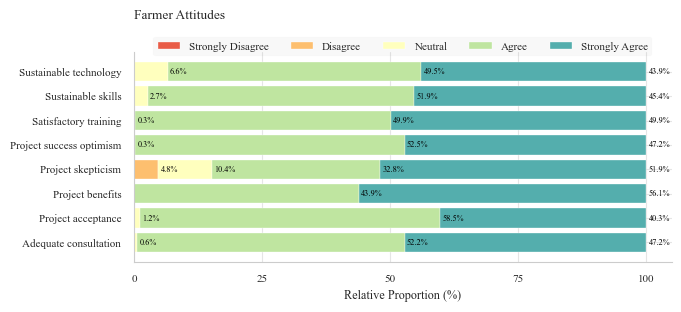

C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(v + df['Strongly Disagree'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(v + df['Strongly Disagree'][i] + df['Disagree'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alw

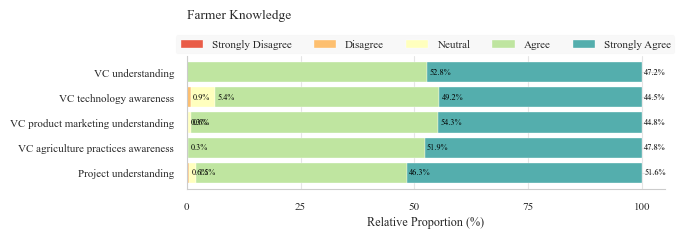

C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(v + df['Strongly Disagree'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(v + df['Strongly Disagree'][i] + df['Disagree'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alw

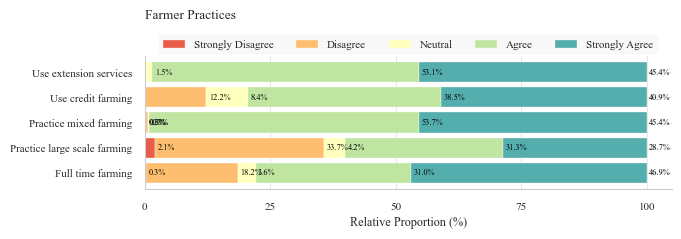

In [77]:
fig, ax = plt.subplots(figsize=(6.7, 3))

ax = bar_plot(farmer_attitudes_pivoted, ax)

ax.set_title('Farmer Attitudes', y=1.12, loc='left')
ax.set_xlabel('Relative Proportion (%)')
ax.set_ylabel('')
ax.set_xticks(np.arange(0, 101, 25))
ax.set_xticklabels(np.arange(0, 101, 25))
ax.set_xlim(0, 105)
ax.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.1),
          facecolor='gray', framealpha=0.05)

sns.despine()
plt.show()

fig, ax = plt.subplots(figsize=(6.7, 2.25))

ax = bar_plot(farmer_knowledge_pivoted, ax)

ax.set_title('Farmer Knowledge', y=1.22, loc='left')
ax.set_xlabel('Relative Proportion (%)')
ax.set_ylabel('')
ax.set_xticks(np.arange(0, 101, 25))
ax.set_xticklabels(np.arange(0, 101, 25))
ax.set_xlim(0, 105)
ax.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.2),
          facecolor='gray', framealpha=0.05)

sns.despine()
plt.show()

fig, ax = plt.subplots(figsize=(6.7, 2.25))

ax = bar_plot(farmer_practices_pivoted, ax)

ax.set_title('Farmer Practices', y=1.22, loc='left')
ax.set_xlabel('Relative Proportion (%)')
ax.set_ylabel('')
ax.set_xticks(np.arange(0, 101, 25))
ax.set_xticklabels(np.arange(0, 101, 25))
ax.set_xlim(0, 105)
ax.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.2),
          facecolor='gray', framealpha=0.05)

sns.despine()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(v + df['Strongly Disagree'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(v + df['Strongly Disagree'][i] + df['Disagree'][i] + 0.5, i - 0.1, f"{v:.1f}%", color='black', fontsize=6)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11060\3359328557.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alw

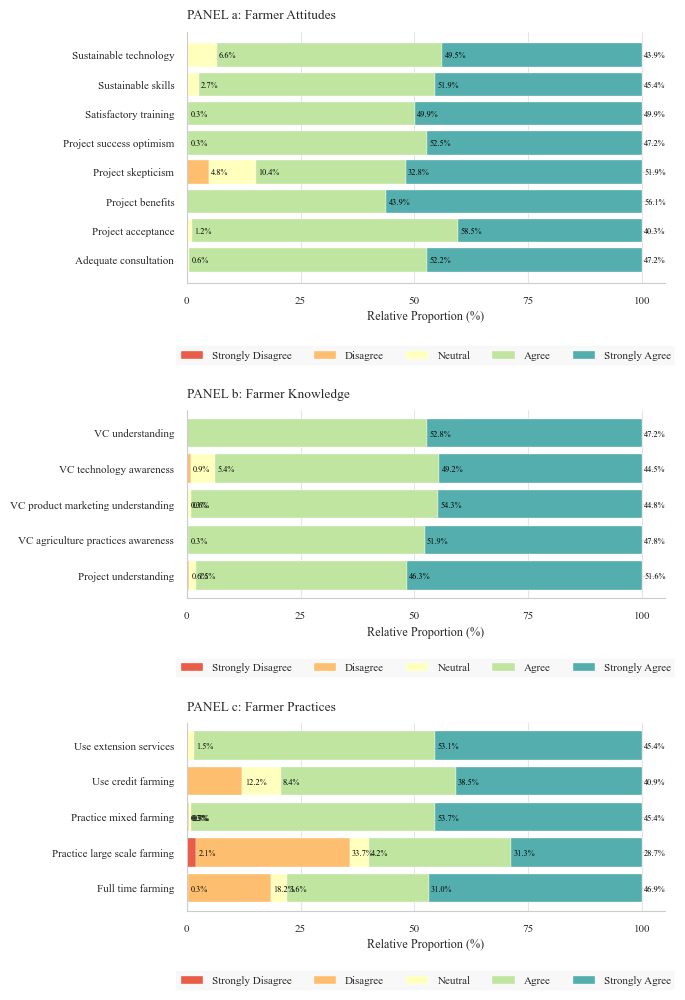

In [78]:
fig, ax = plt.subplots(3, 1, figsize=(6.7, 9.8), gridspec_kw={'hspace': 0.1, 'height_ratios': [4, 3, 3]})

ax[0] = bar_plot(farmer_attitudes_pivoted, ax[0])
ax[1] = bar_plot(farmer_knowledge_pivoted, ax[1])
ax[2] = bar_plot(farmer_practices_pivoted, ax[2])

ax[0].set_title('PANEL a: Farmer Attitudes', y=1.02, loc='left')
ax[1].set_title('PANEL b: Farmer Knowledge', y=1.02, loc='left')
ax[2].set_title('PANEL c: Farmer Practices', y=1.02, loc='left')

ax[0].set_xlabel('Relative Proportion (%)')
ax[1].set_xlabel('Relative Proportion (%)')
ax[2].set_xlabel('Relative Proportion (%)')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xticks(np.arange(0, 101, 25))
ax[1].set_xticks(np.arange(0, 101, 25))
ax[2].set_xticks(np.arange(0, 101, 25))

ax[0].set_xticklabels(np.arange(0, 101, 25))
ax[1].set_xticklabels(np.arange(0, 101, 25))
ax[2].set_xticklabels(np.arange(0, 101, 25))

ax[0].legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.35),
             facecolor='gray', framealpha=0.05)
ax[1].legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.45),
                facecolor='gray', framealpha=0.05)
ax[2].legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.45),
                facecolor='gray', framealpha=0.05)



ax[0].set_xlim(0, 105)
ax[1].set_xlim(0, 105)
ax[2].set_xlim(0, 105)

sns.despine()

plt.show()

In [79]:
farmer_demographics = farmer_demographics.rename(columns={col: col.replace(' ', '_').lower() for col in farmer_demographics.columns})
farmer_attitudes = farmer_attitudes.rename(columns={col: col.replace(' ', '_').lower() for col in farmer_attitudes.columns})
farmer_knowledge = farmer_knowledge.rename(columns={col: col.replace(' ', '_').lower() for col in farmer_knowledge.columns})
farmer_practices = farmer_practices.rename(columns={col: col.replace(' ', '_').lower() for col in farmer_practices.columns})
performance = performance.rename(columns={col: col.replace(' ', '_').lower() for col in performance.columns})

# display(performance)

performance = create_composite_feature(performance, performance.columns.tolist(), 'performance_index',
                                       method='mean', weights=None, drop_features=False, ordinal_map=None)

# display(performance)

farmer_demographics = pd.concat([farmer_demographics, performance['performance_index']], axis=1)
farmer_attitudes = pd.concat([farmer_attitudes, performance['performance_index']], axis=1)
farmer_knowledge = pd.concat([farmer_knowledge, performance['performance_index']], axis=1)
farmer_practices = pd.concat([farmer_practices, performance['performance_index']], axis=1)

# Set all object columns to category
for df in [farmer_demographics, farmer_attitudes, farmer_knowledge, farmer_practices]:
    for col in df.select_dtypes('object').columns:
        df[col] = df[col].astype('category')

In [80]:
from scipy.stats import ttest_ind, f_oneway
import pingouin as pg

# for col in farmer_demographics.select_dtypes('category').columns:
#     unique_values = farmer_demographics[col].unique()
# 
#     # Perform t-test if there are two unique values
#     if len(unique_values) == 2:
#         group1 = farmer_demographics[farmer_demographics[col] == unique_values[0]]['project_performance']
#         group2 = farmer_demographics[farmer_demographics[col] == unique_values[1]]['project_performance']
#         t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
#         print(f"T-Test for {col}: p-value = {p_value:.4f}")
# 
#     # Perform ANOVA if there are more than two unique values
#     elif len(unique_values) > 2:
#         model = pg.anova(data=farmer_demographics, dv='project_performance', between=col)
#         if model['p-unc'][0] < 0.05:
#             print(f"ANOVA for {col}: p-value = {model['p-unc'][0]:.4f}")
# 
#             # Perform pairwise t-tests if ANOVA is significant
#             posthoc = pg.pairwise_tests(data=farmer_demographics, dv='project_performance', between=col)
#             if all(posthoc['p-unc'] < 0.05):
#                 print(f"Pairwise T-Tests for {col}: All comparisons are significant")
#             else:
#                 print(f"Pairwise T-Tests for {col}: Not all comparisons are significant")
#                 display(posthoc, posthoc[posthoc['p-unc'] < 0.05])
                
def conduct_hypothesis_test(df, column):
    
    for col in df.select_dtypes('category').columns:
        unique_values = df[col].unique()

        # Perform t-test if there are two unique values
        if len(unique_values) == 2:
            group1 = df[df[col] == unique_values[0]][column]
            group2 = df[df[col] == unique_values[1]][column]
            t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
            print(f"T-Test for {col}: p-value = {p_value:.4f}")

        # Perform ANOVA if there are more than two unique values
        elif len(unique_values) > 2:
            model = pg.anova(data=df, dv=column, between=col)
            if model['p-unc'][0] < 0.05:
                print(f"ANOVA for {col}: p-value = {model['p-unc'][0]:.4f}")

                # Perform pairwise t-tests if ANOVA is significant
                # posthoc = pg.pairwise_tests(data=df, dv=column, between=col)
                # if all(posthoc['p-unc'] < 0.05):
                #     print(f"Pairwise T-Tests for {col}: All comparisons are significant")
                # else:
                #     print(f"Pairwise T-Tests for {col}: Not all comparisons are significant")
                #     # display(posthoc)
                #     display(posthoc[posthoc['p-unc'] < 0.05])
                    
conduct_hypothesis_test(farmer_demographics, 'performance_index')

T-Test for sub_county: p-value = 0.0000
ANOVA for ward: p-value = 0.0000
T-Test for gender: p-value = 0.1022
T-Test for family_head: p-value = 0.0570
ANOVA for value_chain: p-value = 0.0000


In [81]:
conduct_hypothesis_test(farmer_attitudes, 'performance_index') 


ANOVA for project_skepticism: p-value = 0.0000
ANOVA for adequate_consultation: p-value = 0.0000
ANOVA for project_acceptance: p-value = 0.0000
ANOVA for satisfactory_training: p-value = 0.0000
ANOVA for project_success_optimism: p-value = 0.0000
T-Test for project_benefits: p-value = 0.0000
ANOVA for sustainable_skills: p-value = 0.0000
ANOVA for sustainable_technology: p-value = 0.0000


In [82]:
conduct_hypothesis_test(farmer_knowledge, 'performance_index')

ANOVA for project_understanding: p-value = 0.0000
T-Test for vc_understanding: p-value = 0.0000
ANOVA for vc_agriculture_practices_awareness: p-value = 0.0000
ANOVA for vc_technology_awareness: p-value = 0.0000
ANOVA for vc_product_marketing_understanding: p-value = 0.0000


In [83]:
conduct_hypothesis_test(farmer_practices, 'performance_index')

ANOVA for practice_mixed_farming: p-value = 0.0000
ANOVA for practice_large_scale_farming: p-value = 0.0000
ANOVA for use_extension_services: p-value = 0.0000
ANOVA for use_credit_farming: p-value = 0.0000
ANOVA for full_time_farming: p-value = 0.0000


In [84]:
farmer_attitudes = create_composite_feature(farmer_attitudes, farmer_attitudes.columns.tolist(), 'farmer_attitudes_index',
                                             method='mean', weights=None, drop_features=False, ordinal_map=ordinal_map)
farmer_knowledge = create_composite_feature(farmer_knowledge, farmer_knowledge.columns.tolist(), 'farmer_knowledge_index',
                                             method='mean', weights=None, drop_features=False, ordinal_map=ordinal_map)
farmer_practices = create_composite_feature(farmer_practices, farmer_practices.columns.tolist(), 'farmer_practices_index',
                                             method='mean', weights=None, drop_features=False, ordinal_map=ordinal_map)

for df in [farmer_attitudes, farmer_knowledge, farmer_practices]:
    for col in df.select_dtypes('category').columns:
        df[col] = df[col].astype('int64')

farmer_demographics = farmer_demographics[['performance_index'] + farmer_demographics.columns.tolist()[:-1]]
farmer_attitudes = farmer_attitudes[['performance_index', 'farmer_attitudes_index'] + farmer_attitudes.columns.tolist()[:-2]]
farmer_knowledge = farmer_knowledge[['performance_index', 'farmer_knowledge_index'] + farmer_knowledge.columns.tolist()[:-2]]
farmer_practices = farmer_practices[['performance_index', 'farmer_practices_index'] + farmer_practices.columns.tolist()[:-2]]

In [85]:
farmer_demographics

,performance_index,county,sub_county,ward,geometry,gender,age,education,monthly_income,household_size,family_head,value_chain,vc_experience
0,1.833333,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,64,Secondary,30000,3,Yes,Tomato,40
1,2.000000,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,67,Secondary,20000,4,Yes,Tomato,20
2,2.000000,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,33,Primary,5000,3,No,Tomato,5
3,1.833333,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,73,Primary,800,6+,No,Tomato,2
4,2.000000,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,71,Secondary,10000,5,Yes,Tomato,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,1.000000,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,85,Primary,16000,6+,No,Indigenous chicken,18
331,1.000000,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,54,Primary,14000,6+,Yes,Indigenous chicken,15
332,1.000000,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,60,Primary,16000,6+,Yes,Indigenous chicken,20
333,2.000000,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,62,Primary,4500,5,No,Indigenous chicken,6


In [86]:
farmer_demg = pd.concat([farmer_demographics.select_dtypes('number'), farmer_demographics[['ward', 'value_chain']]], axis=1)
farmer_demg = pd.get_dummies(farmer_demg, columns=['ward', 'value_chain'], drop_first=False)

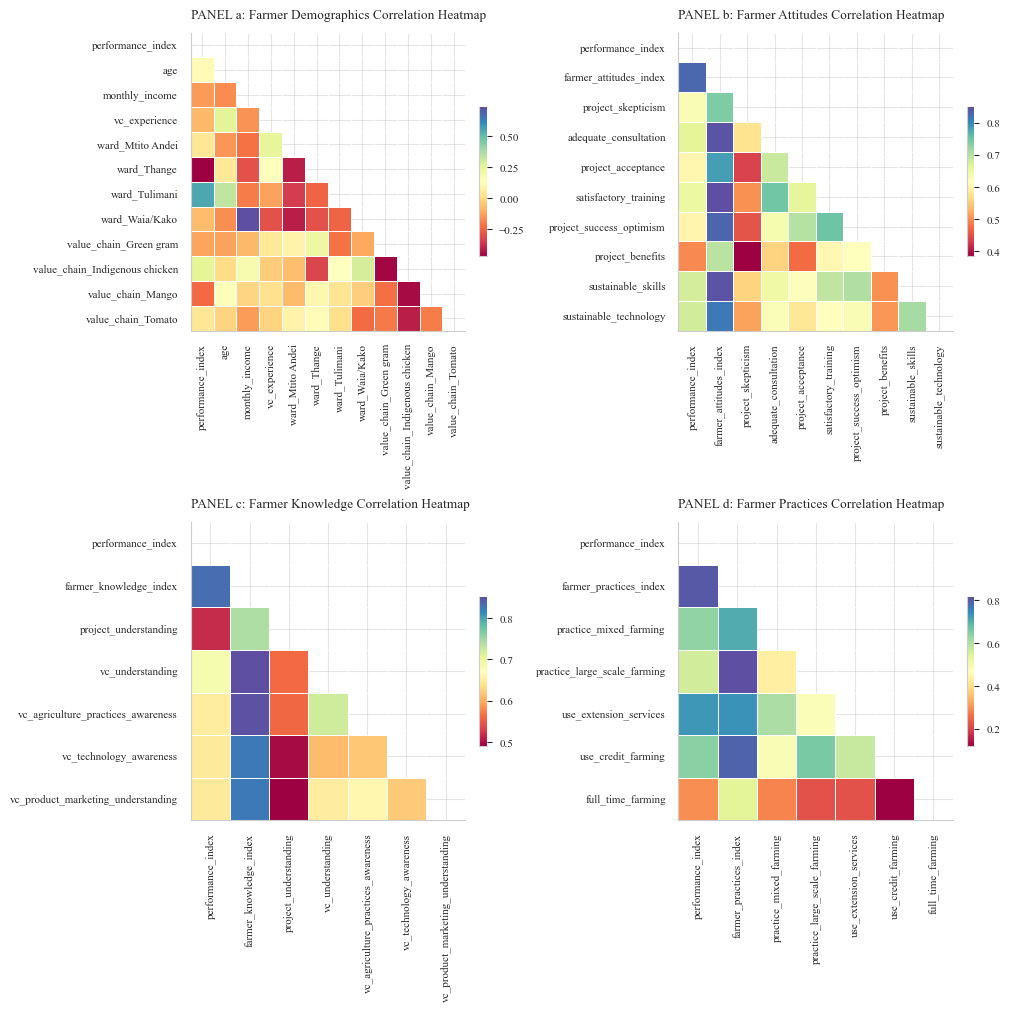

In [87]:
demg_corr = farmer_demg.corr()
demg_mask = np.triu(np.ones_like(demg_corr, dtype=bool))
att_corr = farmer_attitudes.select_dtypes('number').corr()
att_mask = np.triu(np.ones_like(att_corr, dtype=bool))
know_corr = farmer_knowledge.select_dtypes('number').corr()
know_mask = np.triu(np.ones_like(know_corr, dtype=bool))
prac_corr = farmer_practices.select_dtypes('number').corr()
prac_mask = np.triu(np.ones_like(prac_corr, dtype=bool))

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# ADD
sns.heatmap(demg_corr, mask=demg_mask, cmap='Spectral', cbar=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=False, fmt='.2f', ax=ax[0,0])
sns.heatmap(att_corr, mask=att_mask, cmap='Spectral', cbar=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=False, fmt='.2f', ax=ax[0,1])
sns.heatmap(know_corr, mask=know_mask, cmap='Spectral', cbar=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=False, fmt='.2f', ax=ax[1,0])
sns.heatmap(prac_corr, mask=prac_mask, cmap='Spectral', cbar=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=False, fmt='.2f', ax=ax[1,1])

ax[0,0].set_title('PANEL a: Farmer Demographics Correlation Heatmap', y=1.02, loc='left')
ax[0,1].set_title('PANEL b: Farmer Attitudes Correlation Heatmap', y=1.02, loc='left')
ax[1,0].set_title('PANEL c: Farmer Knowledge Correlation Heatmap', y=1.02, loc='left')
ax[1,1].set_title('PANEL d: Farmer Practices Correlation Heatmap', y=1.02, loc='left')

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')
ax[0,0].set_ylabel('')
ax[0,1].set_ylabel('')
ax[1,0].set_ylabel('')
ax[1,1].set_ylabel('')

sns.despine()

plt.show()

,performance_index,farmer_attitudes_index,farmer_knowledge_index,farmer_practices_index
performance_index,1.00,0.83,0.83,0.80
farmer_attitudes_index,0.83,1.00,0.86,0.80
farmer_knowledge_index,0.83,0.86,1.00,0.78
farmer_practices_index,0.80,0.80,0.78,1.00


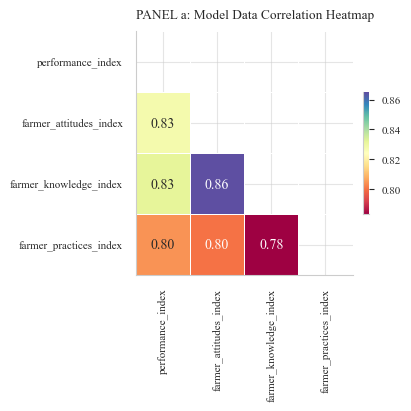

ValueError: Shape of passed values is (10, 3), indices imply (10, 1)

In [88]:
reduced_data = pd.concat([farmer_demg['performance_index'], farmer_attitudes['farmer_attitudes_index'], farmer_knowledge['farmer_knowledge_index'], farmer_practices['farmer_practices_index']], axis=1)

reduced_corr = reduced_data.corr()
reduced_mask = np.triu(np.ones_like(reduced_corr, dtype=bool))

display(reduced_corr.round(2))

fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(reduced_corr, mask=reduced_mask, cmap='Spectral', cbar=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=True, fmt='.2f', ax=ax)

ax.set_title('PANEL a: Model Data Correlation Heatmap', y=1.02, loc='left')

ax.set_xlabel('')
ax.set_ylabel('')

sns.despine()

plt.show()

fa = FactorAnalyzer(rotation='varimax')

# Perform factor analysis on the farmer attitudes data
fa.fit(farmer_attitudes.select_dtypes('number'))

# Get the factor loadings
att_loadings = fa.loadings_

# Create a dataframe of the factor loadings
att_loadings_df = pd.DataFrame(att_loadings, index=farmer_attitudes.select_dtypes('number').columns, columns=['Factor 1'])

# Get the factor variance
att_var = fa.get_factor_variance()

# Create a dataframe of the factor variance
att_var_df = pd.DataFrame(att_var, index=['SS Loadings', 'Proportion Var', 'Cumulative Var'], columns=['Factor 1'])

att_var_df

In [ ]:
model_data = pd.concat([farmer_demg, reduced_data.iloc[:,1:]], axis=1)
model_data

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(9, 5), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

sns.regplot(data=model_data, x='farmer_attitudes_index', y='performance_index', color=palette[0], line_kws={'color':palette[-1]}, scatter_kws={'alpha': 0.5}, ax=ax[0,0])
sns.regplot(data=model_data, x='farmer_knowledge_index', y='performance_index', color=palette[0], line_kws={'color':palette[-1]}, scatter_kws={'alpha': 0.5}, ax=ax[0,1])
sns.regplot(data=model_data, x='farmer_practices_index', y='performance_index', color=palette[0], line_kws={'color':palette[-1]}, scatter_kws={'alpha': 0.5}, ax=ax[0,2])
sns.regplot(data=model_data, x='age', y='performance_index', color=palette[0], line_kws={'color':palette[-1]}, scatter_kws={'alpha': 0.5}, ax=ax[1,0])
sns.regplot(data=model_data, x='vc_experience', y='performance_index', color=palette[0], line_kws={'color':palette[-1]}, scatter_kws={'alpha': 0.5}, ax=ax[1,1])
sns.regplot(data=model_data, x='monthly_income', y='performance_index', color=palette[0], line_kws={'color':palette[-1]}, scatter_kws={'alpha': 0.5}, ax=ax[1,2])

ax[0,0].set_title('PANEL a: Farmer Attitudes vs. Performance', y=1.02, loc='left')
ax[0,1].set_title('PANEL b: Farmer Knowledge vs. Performance', y=1.02, loc='left')
ax[0,2].set_title('PANEL c: Farmer Practices vs. Performance', y=1.02, loc='left')
ax[1,0].set_title('PANEL d: Age vs. Performance', y=1.02, loc='left')
ax[1,1].set_title('PANEL e: Value Chain Experience vs. Performance', y=1.02, loc='left')
ax[1,2].set_title('PANEL f: Monthly Income vs. Performance', y=1.02, loc='left')

ax[0,0].set_xlabel('Farmer Attitudes Index')
ax[0,1].set_xlabel('Farmer Knowledge Index')
ax[0,2].set_xlabel('Farmer Practices Index')
ax[1,0].set_xlabel('Age (Years)')
ax[1,1].set_xlabel('Value Chain Experience (Years)')
ax[1,2].set_xlabel('Monthly Income (Ksh)')

ax[0,0].set_ylabel('Performance Index')
ax[0,1].set_ylabel('')
ax[0,2].set_ylabel('')
ax[1,0].set_ylabel('Performance Index')
ax[1,1].set_ylabel('')
ax[1,2].set_ylabel('')

sns.despine()

plt.show()

# fig, ax = plt.subplots(2,4, figsize=(12, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
# 
# sns.regplot(data=model_data, y='value_chain_Green gram', x='performance_index', line_kws={'color':'red'}, scatter_kws={'alpha': 0.5}, ax=ax[0,0], logistic=True)
# sns.regplot(data=model_data, y='value_chain_Indigenous chicken', x='performance_index', line_kws={'color':'red'}, scatter_kws={'alpha': 0.5}, ax=ax[0,1], logistic=True)
# sns.regplot(data=model_data, y='value_chain_Mango', x='performance_index', line_kws={'color':'red'}, scatter_kws={'alpha': 0.5}, ax=ax[0,2], logistic=True)
# sns.regplot(data=model_data, y='value_chain_Tomato', x='performance_index', line_kws={'color':'red'}, scatter_kws={'alpha': 0.5}, ax=ax[0,3], logistic=True)
# sns.regplot(data=model_data, y='ward_Mtito Andei', x='performance_index', line_kws={'color':'red'}, scatter_kws={'alpha': 0.5}, ax=ax[1,0], logistic=True)
# sns.regplot(data=model_data, y='ward_Thange', x='performance_index', line_kws={'color':'red'}, scatter_kws={'alpha': 0.5}, ax=ax[1,1], logistic=True)
# sns.regplot(data=model_data, y='ward_Tulimani', x='performance_index', line_kws={'color':'red'}, scatter_kws={'alpha': 0.5}, ax=ax[1,2], logistic=True)
# sns.regplot(data=model_data, y='ward_Waia/Kako', x='performance_index', line_kws={'color':'red'}, scatter_kws={'alpha': 0.5}, ax=ax[1,3], logistic=True)
# 
# ax[0,0].set_title('PANEL a: Green Gram vs. Performance', y=1.02, loc='left')
# ax[0,1].set_title('PANEL b: Indigenous Chicken vs. Performance', y=1.02, loc='left')
# ax[0,2].set_title('PANEL c: Mango vs. Performance', y=1.02, loc='left')
# ax[0,3].set_title('PANEL d: Tomato vs. Performance', y=1.02, loc='left')
# ax[1,0].set_title('PANEL e: Mtito Andei vs. Performance', y=1.02, loc='left')
# ax[1,1].set_title('PANEL f: Thange vs. Performance', y=1.02, loc='left')
# ax[1,2].set_title('PANEL g: Tulimani vs. Performance', y=1.02, loc='left')
# ax[1,3].set_title('PANEL h: Waia/Kako vs. Performance', y=1.02, loc='left')
# 
# ax[0,0].set_xlabel('Green Gram')
# ax[0,1].set_xlabel('Indigenous Chicken')
# ax[0,2].set_xlabel('Mango')
# ax[0,3].set_xlabel('Tomato')
# ax[1,0].set_xlabel('Mtito Andei')
# ax[1,1].set_xlabel('Thange')
# ax[1,2].set_xlabel('Tulimani')
# ax[1,3].set_xlabel('Waia/Kako')
# 
# ax[0,0].set_ylabel('Performance Index')
# ax[0,1].set_ylabel('')
# ax[0,2].set_ylabel('')
# ax[0,3].set_ylabel('')
# ax[1,0].set_ylabel('Performance Index')
# ax[1,1].set_ylabel('')
# ax[1,2].set_ylabel('')
# ax[1,3].set_ylabel('')
# 
# sns.despine()
# 
# plt.show()

In [ ]:
X4 = model_data[['farmer_attitudes_index', 'farmer_knowledge_index', 'farmer_practices_index']]
X1 = model_data[['farmer_attitudes_index']]
X2 = model_data[['farmer_knowledge_index']]
X3 = model_data[['farmer_practices_index']]
X5 = model_data[['age', 'vc_experience', 'monthly_income']]
y = model_data['performance_index']

X1 = sm.add_constant(X1)
X2 = sm.add_constant(X2)
X3 = sm.add_constant(X3)
X4 = sm.add_constant(X4)
X5 = sm.add_constant(X5)

model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()
model4 = sm.OLS(y, X4).fit()
model5 = sm.OLS(y, X5).fit()

print(model1.summary())
print(model2.summary())
print(model3.summary())
print(model4.summary())
print(model5.summary())

In [ ]:
# Econometric Tests
# Normality
# Homoscedasticity
# Multicollinearity

# Normality
# Shapiro-Wilk Test

statistic_nt1, p_value_nt1 = shapiro(model1.resid)
statistic_nt2, p_value_nt2 = shapiro(model2.resid)
statistic_nt3, p_value_nt3 = shapiro(model3.resid)
statistic_nt4, p_value_nt4 = shapiro(model4.resid)
statistic_nt5, p_value_nt5 = shapiro(model5.resid)

print(f"Shapiro-Wilk Test for Normality (Model 1): Statistic = {statistic_nt1:.4f}, p-value = {p_value_nt1:.4f}")
print(f"Shapiro-Wilk Test for Normality (Model 2): Statistic = {statistic_nt2:.4f}, p-value = {p_value_nt2:.4f}")
print(f"Shapiro-Wilk Test for Normality (Model 3): Statistic = {statistic_nt3:.4f}, p-value = {p_value_nt3:.4f}")
print(f"Shapiro-Wilk Test for Normality (Model 4): Statistic = {statistic_nt4:.4f}, p-value = {p_value_nt4:.4f}")
print(f"Shapiro-Wilk Test for Normality (Model 5): Statistic = {statistic_nt5:.4f}, p-value = {p_value_nt5:.4f}")

# Homoscedasticity

statistic_ht1, p_value_ht1, f_statistic_ht1, f_p_value_ht1 = het_breuschpagan(model1.resid, model1.model.exog)
statistic_ht2, p_value_ht2, f_statistic_ht2, f_p_value_ht2 = het_breuschpagan(model2.resid, model2.model.exog)
statistic_ht3, p_value_ht3, f_statistic_ht3, f_p_value_ht3 = het_breuschpagan(model3.resid, model3.model.exog)
statistic_ht4, p_value_ht4, f_statistic_ht4, f_p_value_ht4 = het_breuschpagan(model4.resid, model4.model.exog)
statistic_ht5, p_value_ht5, f_statistic_ht5, f_p_value_ht5 = het_breuschpagan(model5.resid, model5.model.exog)

print(f"Breusch-Pagan Test for Homoscedasticity (Model 1): Statistic = {statistic_ht1:.4f}, p-value = {p_value_ht1:.4f}, F-Statistic = {f_statistic_ht1:.4f}, F p-value = {f_p_value_ht1:.4f}")
print(f"Breusch-Pagan Test for Homoscedasticity (Model 2): Statistic = {statistic_ht2:.4f}, p-value = {p_value_ht2:.4f}, F-Statistic = {f_statistic_ht2:.4f}, F p-value = {f_p_value_ht2:.4f}")
print(f"Breusch-Pagan Test for Homoscedasticity (Model 3): Statistic = {statistic_ht3:.4f}, p-value = {p_value_ht3:.4f}, F-Statistic = {f_statistic_ht3:.4f}, F p-value = {f_p_value_ht3:.4f}")
print(f"Breusch-Pagan Test for Homoscedasticity (Model 4): Statistic = {statistic_ht4:.4f}, p-value = {p_value_ht4:.4f}, F-Statistic = {f_statistic_ht4:.4f}, F p-value = {f_p_value_ht4:.4f}")

# Multicollinearity
# Variance Inflation Factor (VIF)

vif1 = pd.DataFrame()
vif1['VIF'] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif1['feature'] = X1.columns
vif1 = vif1.round(2)
display(vif1)

vif2 = pd.DataFrame()
vif2['VIF'] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif2['feature'] = X2.columns
vif2 = vif2.round(2)
display(vif2)

vif3 = pd.DataFrame()
vif3['VIF'] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif3['feature'] = X3.columns
vif3 = vif3.round(2)
display(vif3)

vif4 = pd.DataFrame()
vif4['VIF'] = [variance_inflation_factor(X4.values, i) for i in range(X4.shape[1])]
vif4['feature'] = X4.columns
vif4 = vif4.round(2)
display(vif4)

vif5 = pd.DataFrame()
vif5['VIF'] = [variance_inflation_factor(X5.values, i) for i in range(X5.shape[1])]
vif5['feature'] = X5.columns
vif5 = vif5.round(2)
display(vif5)

In [ ]:
# Create a single figure
fig, ax = plt.subplots(1,2, figsize=(8, 4), gridspec_kw={'wspace': 0.1})

# Plot Kenya
kenya.plot(ax=ax[0], color='white', edgecolor='black', linewidth=0.5)
ax[0].set_title('PANEL a: Map of Kenya', y=1.01, loc='left')  # Set title alignment to left

# Plot Makueni County
makueni_county.plot(ax=ax[0], color=palette[0], edgecolor='black')

# Annotate Makueni County
centroid = makueni_county.iloc[0].geometry.centroid
annotation = ax[0].annotate('Makueni', xy=(centroid.x, centroid.y), xytext=(25, 15),
                            textcoords="offset points", color='black', fontsize=8, ha='center',
                            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
                            arrowprops=dict(arrowstyle='->', color='black'))

# Plot Makueni County separately
makueni_county.plot(ax=ax[1], color='white', edgecolor='black', linewidth=0.5)
ax[1].set_title('PANEL b: Map of Makueni County - NARIGP Locations', y=1.01, loc='left')  # Set title alignment to left

# Plot Makueni wards
makueni_wards.plot(ax=ax[1], color='white', edgecolor='black', linewidth=0.25)
narig_wards.plot(ax=ax[1], color=palette[-2], edgecolor='black', linewidth = 0.1, alpha=0.5)

# Annotate Makueni County in the second plot
# annotation2 = ax[1].annotate('Makueni', xy=(makueni_county.geometry.centroid.x, makueni_county.geometry.centroid.y),
#xytext=(30, 0), textcoords="offset points", color='black', fontsize=8, ha='center')

# Plot survey points
# Set colors for each ward

# palette = sns.color_palette('Blues', 5)
# palette.reverse()

# Update palette
colors = {'Tulimani': palette[-1],
          'Waia/Kako': palette[-1],
          'Mtito Andei': palette[-1],
          'Thange': palette[-1]}

survey.plot(ax=ax[1], edgecolor='black', linewidth=0.25, color=survey['ward'].map(colors), legend=True)

# Plot Makueni Sub Counties
# makueni_sub_counties.plot(ax=ax[1], edgecolor='black', linewidth=0.75)

# Add gray to the legend indicating NARIG locations
handles, labels = ax[1].get_legend_handles_labels()
# handles.append(plt.Line2D([], [], color='#909CC2', marker='o', linestyle='None'))
# labels.append('Tulimani')
# handles.append(plt.Line2D([], [], color='#084887', marker='o', linestyle='None'))
# labels.append('Waia/Kako')
# handles.append(plt.Line2D([], [], color='#F58A07', marker='o', linestyle='None'))
# labels.append('Mtito Andei')
# handles.append(plt.Line2D([], [], color='#F9AB55', marker='o', linestyle='None'))
# labels.append('Thange')
handles.append(plt.Line2D([], [], color=palette[-2], marker='o', linestyle='None'))
labels.append('Other NARIGP Wards')
ax[1].legend(handles=handles, labels=labels, loc='upper right', ncol=1, bbox_to_anchor=(1, 0.95), facecolor='white', edgecolor='black', framealpha=0.1)

# palette = sns.color_palette('Blues', 5)
# palette.reverse()
# 
# # Update palette
# ax[1].get_legend().get_texts()[0].set_color(palette[0])
# ax[1].get_legend().get_texts()[1].set_color(palette[1])
# ax[1].get_legend().get_texts()[2].set_color(palette[2])
# ax[1].get_legend().get_texts()[3].set_color(palette[3])
# ax[1].get_legend().get_texts()[4].set_color(palette[4])


# Add titles and labels
fig.suptitle("Makueni's Position in Kenya Alongside A Map of The County", x=0.08, y=1.1, ha='left')  # Set title alignment to left
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# Get unique geometries from the dataframe
unique_geometries = narig_dfs['survey_df'].drop_duplicates(subset='geometry')

# Add annotations individually
tulimani = unique_geometries[unique_geometries['ward'] == 'Tulimani']
tulimani_centroid = tulimani.iloc[0].geometry.centroid
ax[1].annotate('Tulimani', xy=(tulimani_centroid.x, tulimani_centroid.y),
            xytext=(-35, 12), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

kako = unique_geometries[unique_geometries['ward'] == 'Waia/Kako']
kako_centroid = kako.iloc[0].geometry.centroid
ax[1].annotate('Waia/Kako', xy=(kako_centroid.x, kako_centroid.y),
            xytext=(10, 25), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

mtito = unique_geometries[unique_geometries['ward'] == 'Mtito Andei']
mtito_centroid = mtito.iloc[0].geometry.centroid
ax[1].annotate('Mtito Andei', xy=(mtito_centroid.x, mtito_centroid.y),
            xytext=(-30, -30), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

thange = unique_geometries[unique_geometries['ward'] == 'Thange']
thange_centroid = thange.iloc[0].geometry.centroid
ax[1].annotate('Thange', xy=(thange_centroid.x, thange_centroid.y),
            xytext=(-45, -15), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

## Remove axes
# ax[0].set_axis_off()
# ax[1].set_axis_off()

# Add a compass rose
ax[0].annotate('N', xy=(0.5, 0.975), xytext=(0.5, 0.90), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))
ax[0].annotate('S', xy=(0.5, 0.025), xytext=(0.5, 0.10), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))
ax[0].annotate('E', xy=(0.975, 0.5), xytext=(0.90, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))
ax[0].annotate('W', xy=(0.025, 0.5), xytext=(0.10, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))

ax[1].annotate('N', xy=(0.5, 0.975), xytext=(0.5, 0.90), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))
ax[1].annotate('S', xy=(0.5, 0.025), xytext=(0.5, 0.10), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))
ax[1].annotate('E', xy=(0.975, 0.5), xytext=(0.90, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))
ax[1].annotate('W', xy=(0.025, 0.5), xytext=(0.10, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))
# Add a border to the figure
# fig.patch.set_edgecolor('black')
# ax[0].spines['top'].set_visible(False)
# ax[0].spines['right'].set_visible(False)
# ax[1].spines['top'].set_visible(False)
# ax[1].spines['right'].set_visible(False)

plt.show()

In [ ]:
# narig_dfs['survey_df'][numeric_cols].hist(figsize=(9,9))
# plt.show()


def filter_outliers(dataframe: pd.DataFrame, columns: list):

    for col in columns:

        mean = dataframe[col].mean()
        std = dataframe[col].std()
        limit = std * 3

        lower, upper = (mean - limit), (mean + limit)

        dataframe = dataframe[(dataframe[col] > lower) &
                                   (dataframe[col] < upper)]

        return dataframe

df_outliers = filter_outliers(narig_dfs['survey_df'], numeric_cols)

df_outliers[numeric_cols].hist(figsize=(9,9))
plt.show()


# survey.hist('vc_experience')
# plt.show()

# mean_vce = survey.vc_experience.mean()
# print(mean_vce)
# std_vce = survey.vc_experience.std()
# print(std_vce)
# limit = std_vce * 3
# print(limit)
# lower, upper = mean_vce - limit, mean_vce + limit
# print(lower, ',', upper)

# survey = survey[survey['vc_experience'] < upper]


# # survey['vc_experience'] = survey.vc_experience ** 1/3

# survey.hist('vc_experience')
# plt.show()

# mean_vce = survey.vc_experience.mean()
# print(mean_vce)
# std_vce = survey.vc_experience.std()
# print(std_vce)
# limit = std_vce * 3
# print(limit)
# lower, upper = mean_vce - limit, mean_vce + limit
# print(lower, ',', upper)

# survey = survey[survey['vc_experience'] > upper]

# survey.hist('vc_experience')
# plt.show()

In [ ]:
df_outliers.describe().round(2).T.map(lambda x: int(x) if x.is_integer() else x).rename(columns={'count': 'Count', 'mean': 'Mean', 'std': 'Standard Deviation', 'min': 'Minimum', '25%': '25th Percentile', '50%': '50th Percentile', '75%': '75th Percentile', 'max': 'Maximum'})

In [ ]:
# Plot project_performance on the map
fig, ax = plt.subplots(figsize=(4, 4))

makueni_county.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
makueni_wards.plot(ax=ax, color='white', edgecolor='black', linewidth=0.25)
cax = fig.add_axes([1, 0.2, 0.02, 0.6])  # Reduce the width of the colorbar axes
df_outliers.plot('project_performance', legend=True, ax=ax, cax=cax)  # Add cax parameter to specify the colorbar axes

# Add title and labels
ax.set_title('Project Performance Across NARIG Wards', y=1.01, loc='left')  # Set title alignment to left

# Get unique geometries from the dataframe
unique_geometries = df_outliers.drop_duplicates(subset='geometry')

# Add annotations individually
tulimani = unique_geometries[unique_geometries['ward'] == 'Tulimani']
tulimani_centroid = tulimani.iloc[0].geometry.centroid
ax.annotate('Tulimani', xy=(tulimani_centroid.x, tulimani_centroid.y),
            xytext=(-35, 12), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

kako = unique_geometries[unique_geometries['ward'] == 'Waia/Kako']
kako_centroid = kako.iloc[0].geometry.centroid
ax.annotate('Waia/Kako', xy=(kako_centroid.x, kako_centroid.y),
            xytext=(10, 25), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

mtito = unique_geometries[unique_geometries['ward'] == 'Mtito Andei']
mtito_centroid = mtito.iloc[0].geometry.centroid
ax.annotate('Mtito Andei', xy=(mtito_centroid.x, mtito_centroid.y),
            xytext=(-30, -30), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

thange = unique_geometries[unique_geometries['ward'] == 'Thange']
thange_centroid = thange.iloc[0].geometry.centroid
ax.annotate('Thange', xy=(thange_centroid.x, thange_centroid.y),
            xytext=(-45, -15), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

ax.annotate('N', xy=(0.5, 0.975), xytext=(0.5, 0.90), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))
ax.annotate('S', xy=(0.5, 0.025), xytext=(0.5, 0.10), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))
ax.annotate('E', xy=(0.975, 0.5), xytext=(0.90, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))
ax.annotate('W', xy=(0.025, 0.5), xytext=(0.10, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-|>, widthB=1.5, lengthB=0.75', color='black'))

# Remove axes
# ax.set_axis_off()
# Top and right spines should be off
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.show()

In [ ]:
# # Cuberoot
# for col in df_outliers.select_dtypes('number').columns:
#     df_outliers[col] = df_outliers[col] ** 1/3

In [ ]:
corr = df_outliers[numeric_cols + ['farmer_attitudes', 'farmer_knowledge', 'farmer_practices', 'project_performance']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Sort the correlation matrix by project_performance (both axes)
corr = corr.sort_values(by='project_performance', ascending=False); corr = corr[corr.index]

sns.heatmap(corr, mask=mask, cmap='viridis', linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=True, fmt='.2f', cbar=False, ax=ax[0])
ax[0].set_title('Correlation Matrix', y=1.01, loc='left')
sns.barplot(y=corr['project_performance'].sort_values(ascending=False).values, x=corr['project_performance'].sort_values(ascending=False).index, hue=corr['project_performance'], orient='v', palette=sns.color_palette('Blues', len(corr.columns)), width = 0.5, legend=False, ax=ax[1])
for i, v in enumerate(corr['project_performance'].sort_values(ascending=False).values):
    if v > 0:
        ax[1].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=8)
    else:
        ax[1].text(i, v - 0.01, f"{v:.2f}", ha='center', va='top', fontsize=8)

ax[1].set_xlabel('')
ax[1].set_title('Correlation with Project Performance', y=1.01, loc='left')
ax[1].xaxis.set_tick_params(rotation=90)

ax[0].tick_params(axis='x', which='both', bottom=False)
ax[1].tick_params(axis='x', which='both', bottom=False)

sns.despine()

plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(9, 3))

sns.regplot(data=df_outliers, x='farmer_attitudes', y='project_performance', ax=ax[0], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='farmer_knowledge', y='project_performance', ax=ax[1], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='farmer_practices', y='project_performance', ax=ax[2], scatter_kws={'alpha': 0.5}, logx=False, ci=None)


ax[0].set_title('Farmer Attitudes vs Project Performance', y=1.02, loc='left')
ax[1].set_title('Farmer Knowledge vs Project Performance', y=1.02, loc='left')
ax[2].set_title('Farmer Practices vs Project Performance', y=1.02, loc='left')

ax[0].set_xlabel('Farmer Attitudes')
ax[1].set_xlabel('Farmer Knowledge')
ax[2].set_xlabel('Farmer Practices')

ax[0].set_ylabel('Project Performance')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

sns.despine()

plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(9, 3))

sns.regplot(data=df_outliers, x='age', y='project_performance', ax=ax[0], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='monthly_income', y='project_performance', ax=ax[1], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='vc_experience', y='project_performance', ax=ax[2], scatter_kws={'alpha': 0.5}, logx=False, ci=None)

ax[0].set_title('Age vs Project Performance', y=1.02, loc='left')
ax[1].set_title('Monthly Income vs Project Performance', y=1.02, loc='left')
ax[2].set_title('Value Chain Experience vs Project Performance', y=1.02, loc='left')

ax[0].set_xlabel('Age')
ax[1].set_xlabel('Monthly Income')
ax[2].set_xlabel('Value Chain Experience')

ax[0].set_ylabel('Project Performance')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

sns.despine()

plt.show()

In [ ]:
# Create a figure with boxplots for demographic data against project_performance
fig, ax = plt.subplots(2, 2, figsize=(9, 6), sharey=True)

sns.boxplot(data=df_outliers, x='value_chain', y='project_performance', width=0.25, ax=ax[0,0])
sns.boxplot(data=df_outliers, x='education', y='project_performance', width=0.25, ax=ax[0,1])
sns.boxplot(data=df_outliers, x='gender', y='project_performance', width=0.1, ax=ax[1,0])
sns.boxplot(data=df_outliers, x='family_head', y='project_performance', width=0.1, ax=ax[1,1])

ax[0,0].set_title('Value Chain vs Project Performance', y=1.02, loc='left')
ax[0,1].set_title('Education vs Project Performance', y=1.02, loc='left')
ax